In [1]:
import os
import pandas as pd
import networkx as nx
import numpy as np
import itertools
import json
import collections
from sklearn import linear_model as lm
import matplotlib.pyplot as plt

# Basic Network Measures

# 1. Data

In [2]:
path = str(os.path.abspath(os.path.join('',"./")))
with open(path + '/edgelist_ksw_full_372_30min_25-03-2020.json', 'r') as f:
    edgelist = json.load(f)
with open(path + '/nodelist_ksw_full_372_30min_25-03-2020.json', 'r') as f:
    nodelist = json.load(f)

In [3]:
#nodelist

In [4]:
nodelist = np.array(list(nodelist.items()))
edgelist = np.array(edgelist)

Construct network

In [5]:
G = nx.MultiDiGraph()

In [6]:
for node in nodelist:
    G.add_node(node[0])

In [7]:
for edge in edgelist:
    G.add_edge(edge[0],edge[1],attr_dict = edge[2])

In [8]:
# create network based on area
def create_network_area(areaname):
    nodelist_by_area = nodelist[nodelist[:,1] == areaname,:][:,0]
    edgelist_by_area = edgelist[np.isin(edgelist[:,0],nodelist_by_area) | np.isin(edgelist[:,1],nodelist_by_area),]
    G_area = nx.MultiDiGraph()
    for node in nodelist_by_area:
        G_area.add_node(node[0])
    for edge in edgelist_by_area:
        G_area.add_edge(edge[0],edge[1],attr_dict = edge[2])
    return G_area

In [9]:
NY = create_network_area("New York")

In [10]:
def SSE(a,b):
    """
    Return sum of squared error
    """
    return np.sum(np.power(a-b, 2))

In [11]:
def bootstrap_sample(f, G, s, side, *args):
    """
    Calculate network measure and p-value for a sample of a network
    based on random sampling of nodes
    
    f: function handle, network measure
    G: networx graph, population
    s: networkx graph, filtered sample from G
    side: str, two-sided/left/right
    *args: extra args for network measure
    """
    G_nodes = G.nodes()
    n = len(s.nodes())
    # measure for original sample
    fs = f(s, *args)
    flist = np.zeros(999)
    # calculate measure for random samples of the network
    for i in np.arange(999, dtype = int):
        random_nodes = np.random.choice(G_nodes, size=n, replace=False)
        G_random_sample = G.subgraph(random_nodes)
        flist[i] = f(G_random_sample, *args)
    # calculate p-value
    flist.sort(axis = 0)
    i_leq = 999
    for i in np.arange(999,dtype = int):
        if flist[i] >= fs:
            i_leq = i
            break
    i_leq = i_leq + 1
    if i_leq in [1,1000]:
        p = 0
    elif side == "two-sided":
        if i_leq >=500: i_leq = 1000-i_leq
        p = i_leq/500.
    elif side == "left":
        p = i_leq/1000.
    else:
        p = (1000-i_leq)/1000.
    return fs, p

# 2. Analysis

## 2.1 Visualization

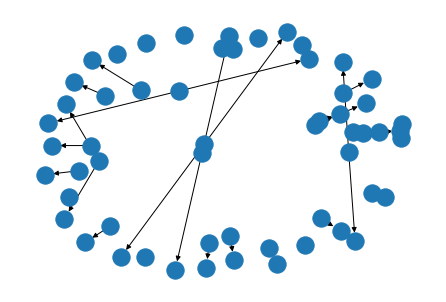

In [30]:
nx.draw(NY)

# 2.2 Degree Distribution
From 'Practical Social Network Analysis with Python':

In practice, few empirical phenomena obey power laws for all values ofx.Moreoften the power law applies only for values greater than some minimumxmin. In suchcases we say that the tail of the distribution follows a power law.\
Broadly, the steps to verify power-law exhibition by a dataset is as follows:\
1. Estimate the parameters xmin and α of the power-law model using maximum likelihood estimation (MLE) techniques.\
2. Calculate the goodness-of-fit between the data and the power law. If the resulting p-value is greater than 0.1 the power law is a plausible hypothesis for the data,otherwise it is rejected.\
3. Compare the power law with alternative hypotheses via a likelihood ratio test. Foreach alternative, if the calculated likelihood ratio is significantly different fromzero, then its sign indicates whether the alternative is favoured over the power-lawmodel or not. Other established and statistically principled approaches for modelcomparison, such as a fully Bayesian approach [9], a cross-validation approach[17], or a minimum description length approach [8] can also be used instead.\

The power law has several moniker in various fields. It goes by the term Lotkadistribution for scientific productivity [15], Bradford law for journal use [4], Paretolaw of income distribution [16] and the Zipf law for literary word frequencies.

So: \
fit power law, calculate error, \
Bootstrap results to random sample of same size from the network \ 
\
but first, some plots:

## Histograms for small networks

In [ ]:
k = nx.degree_histogram(NY)
x = np.arange(len(k))
# in-degree
in_degree_sequence = sorted([d for n, d in NY.in_degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
inDegreeCount = collections.Counter(in_degree_sequence)
indeg, incnt = zip(*inDegreeCount.items())
# out-degree
out_degree_sequence = sorted([d for n, d in NY.out_degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
outDegreeCount = collections.Counter(out_degree_sequence)
outdeg, outcnt = zip(*outDegreeCount.items())


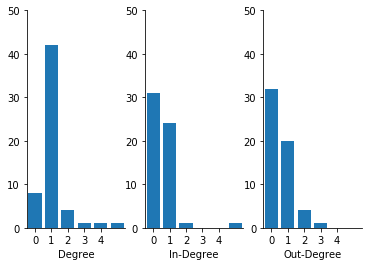

In [68]:
fig, axs = plt.subplots(1,3, frameon = False)
axs[0].bar(x,k)#, width = 1)
axs[0].set_xlabel("Degree")
h

axs[1].bar(indeg,incnt)#, width = 1)
axs[1].set_xlabel("In-Degree")


#k_in = nx.in_degree_histogram(NY)
#x_in = np.arange(len(k_in))
axs[2].bar(outdeg,outcnt)#, width = 1)
axs[2].set_xlabel("Out-Degree")

for ax in axs:
    ax.set_xlim(-0.5,5.5)
    ax.set_ylim(0,50)
    ax.set_xticks(range(5))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

## Log plots for large networks

In [40]:
h = np.array(nx.degree_histogram(G)) 
x = np.arange(h.shape[0])
# in-degree
in_degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
inDegreeCount = collections.Counter(in_degree_sequence)
indeg, incnt = zip(*inDegreeCount.items())
# out-degree
out_degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
outDegreeCount = collections.Counter(out_degree_sequence)
outdeg, outcnt = zip(*outDegreeCount.items())

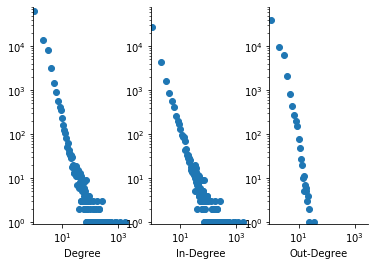

In [67]:
fig, axs = plt.subplots(1,3)
#plt.yscale('log')
axs[0].scatter(x,h)
axs[0].set_xlabel("Degree")
#k_in = nx.in_degree_histogram(NY)
#x_in = np.arange(len(k_in))
axs[1].scatter(indeg,incnt)#, width = 1)
axs[1].set_xlabel("In-Degree")
axs[2].scatter(outdeg,outcnt)#, width = 1)
axs[2].set_xlabel("Out-Degree")

for ax in axs:
    #ax.set_xlim(-0.5,5.5)
    ax.set_ylim(0.9,8e4)
    ax.set_xlim(0.9,3e3)
    #ax.set_xticks(range(5))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yscale('log')
    ax.set_xscale('log')
    


## Power law fits and p-values compared to random sample of network

In [177]:
def degree_power_law_fit(G, *args):
    """
    Fits power law model to degree distribution of network 
    and measured goodness of fit in log-log scale (allowing more deviation in extreme values)
    G: networkx graph
    direction: degree, in_degree or out_degree
    goodness: function for measuring goodness of fit
    """
    degree_func = args[0]
    if len(args) ==2:
        goodness = args[1]
    else:
        goodness = SSE
    # degree distribution
    if degree_func == "degree": 
        degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    elif degree_func == "in_degree":
        degree_sequence = sorted([d for n, d in G.in_degree()], reverse=True)  # degree sequence
    elif degree_func == "out_degree":
        degree_sequence = sorted([d for n, d in G.out_degree()], reverse=True)  # degree sequence
    else:
        raise ValueError("unknown degree distribution function")
    DegreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*DegreeCount.items())
    deg = np.array(deg)
    cnt = np.array(cnt)
    # take log
    deg = np.where(deg != 0, np.log(deg), 0).reshape(-1, 1)#np.log(deg)
    cnt = np.where(cnt != 0, np.log(cnt), 0).reshape(-1, 1)#np.log(deg)
    # linear model of log points
    #if np.count_nonzero(np.isnan(deg)) or np.count_nonzero(np.isnan(cnt)):
    #    print("nan values")
    #model, residuals, rank, singular_values, rcond = np.polyfit(deg,cnt,1, full = True)
    regr = linear_model.LinearRegression()
    # fit model
    regr.fit(deg, cnt)
    # fitted values
    cnt_fit = regr.predict(deg)
    return goodness(cnt,cnt_fit)
    
    

In [139]:
# hide runtime warnings from np.log
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [183]:
# bootstrap NY
bootstrap_sample(degree_power_law_fit, G, NY, "two-sided", "degree")


(1.9383236699487751, 0.05)

In [184]:
# bootstrap NY, in_degree
bootstrap_sample(degree_power_law_fit, G, NY, "two-sided", "in_degree")

(2.6617191647253877, 0.814)

In [186]:
# bootstrap NY, out_degree
bootstrap_sample(degree_power_law_fit, G, NY, "two-sided", "out_degree")

(0.1361017162270848, 0.836)

Here we see that in and out -degrees of New York tweeters (among themselves) are not statistically different from the rest of the network.